Trying to reproduce R workflow from https://academic.oup.com/jncics/article/2/1/pky002/4942295 and https://github.com/mcjarvis/Mutation-Signatures-Including-APOBEC-in-Cancer-Cell-Lines-JNCI-CS-Supplementary-Scripts



Register and download "COSMIC Mutation Data" (CosmicCLP_MutantExport.tsv.gz) from https://cancer.sanger.ac.uk/cell_lines/download
The paper used v81.

https://cog.sanger.ac.uk/cosmic/GRCh38/cell_lines/v81/CosmicCLP_MutantExport.tsv.gz

These use chromosome "23" and "24". I'll have to figure out what these are. X and Y I'm guessing.


```BASH
gunzip CosmicCLP_MutantExport.tsv.gz

cosmic_file=/raid/refs/cosmic/CosmicCLP_MutantExport_v81.tsv

awk 'BEGIN{FS="\t"; OFS="\t"
	comp["A"]="T"
	comp["T"]="A"
	comp["C"]="G"
	comp["G"]="C"
	comp["N"]="N"
}
( $24 != "" ){
	split($24,a,":");split(a[2],b,"-")
	if( $24 != "" && $20 ~ "Substitution" && b[1] == b[2] && !seen[$24] ) {
		chr=a[1];pos=b[1]
		if(chr==23) chr="X"
		if(chr==24) chr="Y"
		cmd="samtools faidx /raid/refs/fasta/hg38_num_noalts.fa "chr":"pos"-"pos" | tail -1 "
		cmd|getline ref1
		close(cmd)
		ref1=toupper(ref1)
		ref2=toupper(substr($18,length($18)-2,1))
		if($25 == "-") ref2=comp[ref2]
		alt=toupper(substr($18,length($18),1))
		if($25 == "-") alt=comp[alt]
		if( ref1 == ref2 ) {
			if( alt == ref1 ){
				print "Nonmutation?"
				print chr, pos, $25, ref1, ref2, alt
			}else{
				file=$5
				gsub("/","_",file)
				print chr, b[1], ref1, substr($18,length($18),1), $25, $5 >> file"-Step4a.tsv"
				close(file"-Step4a.tsv"); seen[$24]++
			}
		}else{
			print "Nonmatching mutation?"
			print chr, pos, $25, ref1, ref2, alt
		}
	}
}' ${cosmic_file}

wc -l *-Step4a.tsv

for f in *-Step4a.tsv ; do n=${f/Step4a/Step4b}; sort -n $f > $n ;  done

# Combine and remove "strand" column
cat *-Step4b.tsv | awk 'BEGIN{FS=OFS="\t"}{print $1,$2,$3,$4,$6}' > cosmic_mut.txt

for i in *-Step4b.tsv; do ./count_trinuc_muts_v8.pl pvcf /raid/refs/fasta/hg38_num_noalts.fa $i; done

rename 's/tsv.\d*.count/count/' *-Step4b.tsv.*.count.txt

head -1 $( ls *count.txt | head -1 ) > cosmic_mut_all_sort.txt
tail -n +2 -q *count.txt >> cosmic_mut_all_sort.txt
```

Now we have cosmic_mut.txt and cosmic_mut_all_sort.txt

The deconstructSigs github repo contains the signatures.nature2013.rda file needed.

I viewed the supplementary spreadsheets associated with the paper which include sample and tissue columns which I extracted to create the cosmic_tissue_type.txt file.

Having those 4 files, I can now do the following, which is heavily modified from the horrible and unrunnable example in the github repository.


In [1]:
require(deconstructSigs)
require(ggplot2)
require(reshape)
require(stringr)
require(plyr)
require(gridExtra)

require(BSgenome.Hsapiens.UCSC.hg38)
hg38 <- BSgenome.Hsapiens.UCSC.hg38

Loading required package: deconstructSigs
Loading required package: ggplot2
Loading required package: reshape
Loading required package: stringr
Warning message:
“package ‘stringr’ was built under R version 3.5.2”Loading required package: plyr

Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any

Loading required package: gridExtra
Loading required package: BSgenome.Hsapiens.UCSC.hg38
Loading required package: BSgenome
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects

In [2]:
cosmic_mut = read.table("cosmic/cosmic_mut.txt",header = F, sep="\t",col.names = c("chr","pos","ref","alt","sample"))

In [3]:
head(cosmic_mut)

chr,pos,ref,alt,sample
X,115719187,T,G,201T
X,141697643,G,G,201T
X,153346872,G,T,201T
X,15347338,G,G,201T
X,21856496,C,T,201T
X,45164212,C,T,201T


In [4]:
cosmic_mut_sort <- with(cosmic_mut, cosmic_mut[order(cosmic_mut[,"sample"]),])
head(cosmic_mut_sort)

chr,pos,ref,alt,sample
X,115719187,T,G,201T
X,141697643,G,G,201T
X,153346872,G,T,201T
X,15347338,G,G,201T
X,21856496,C,T,201T
X,45164212,C,T,201T


In [5]:
rownames(cosmic_mut_sort) <- NULL
head(cosmic_mut_sort)

chr,pos,ref,alt,sample
X,115719187,T,G,201T
X,141697643,G,G,201T
X,153346872,G,T,201T
X,15347338,G,G,201T
X,21856496,C,T,201T
X,45164212,C,T,201T


In [6]:
cosmic_mut_sort$sample <- as.factor(cosmic_mut_sort$sample)
head(cosmic_mut_sort)

chr,pos,ref,alt,sample
X,115719187,T,G,201T
X,141697643,G,G,201T
X,153346872,G,T,201T
X,15347338,G,G,201T
X,21856496,C,T,201T
X,45164212,C,T,201T


In [7]:
cosmic_mut_all_sort <- read.table(file = "cosmic/cosmic_mut_all_sort.txt", header = F, sep = "\t", stringsAsFactors = T)
head(cosmic_mut_all_sort)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
X,115719187,ACAA,CAAC,CAA,T>G,C[T>G]A,-,AAGGAGTCAAGACTGAGAACAACGATCATATTAATTTGAAG,14,8,4,2,2,2,201T
X,141697643,TCCG,CCGA,CCG,G>G,C[G>G]G,-,CTCAGACCCGCAACCTGCTCCGAAAAAACTAAAAACATCTG,19,5,1,2,1,0,201T
X,153346872,AGGA,GGAG,GGA,G>T,G[G>T]A,+,GGGAAGATGCCCAGCCACAGGAGATGGCGTCCACAAGCTTC,25,6,2,2,0,0,201T
X,15347338,ACCA,CCAG,CCA,G>G,C[G>G]A,-,CCACTCTCATCTCCAGGAACCAGCTCTCTGTGGGCCACACA,24,7,1,3,1,0,201T
X,21856496,AACG,ACGA,ACG,C>T,A[C>T]G,+,CTCTCAGCCATGGCCTCCAACGAAGATTTCTCCATCACACA,21,8,4,4,1,1,201T
X,45164212,GTGT,TGTA,TGT,C>T,T[C>T]T,-,GAGAGAACTAAAGTTCCTGTGTATGCTGAGATAACACCAGT,17,6,1,2,1,0,201T


In [8]:
colnames(cosmic_mut_all_sort) <- c("chr", "pos", "5_tetnuc", "3_tetnuc", "trinuc", "mut", "trinuc_mut", "strand", "context", "C_count", "TC_count", "TCA_count", "TCT_count", "YTCA_count", "RTCA_count", "sample")
head(cosmic_mut_all_sort)

chr,pos,5_tetnuc,3_tetnuc,trinuc,mut,trinuc_mut,strand,context,C_count,TC_count,TCA_count,TCT_count,YTCA_count,RTCA_count,sample
X,115719187,ACAA,CAAC,CAA,T>G,C[T>G]A,-,AAGGAGTCAAGACTGAGAACAACGATCATATTAATTTGAAG,14,8,4,2,2,2,201T
X,141697643,TCCG,CCGA,CCG,G>G,C[G>G]G,-,CTCAGACCCGCAACCTGCTCCGAAAAAACTAAAAACATCTG,19,5,1,2,1,0,201T
X,153346872,AGGA,GGAG,GGA,G>T,G[G>T]A,+,GGGAAGATGCCCAGCCACAGGAGATGGCGTCCACAAGCTTC,25,6,2,2,0,0,201T
X,15347338,ACCA,CCAG,CCA,G>G,C[G>G]A,-,CCACTCTCATCTCCAGGAACCAGCTCTCTGTGGGCCACACA,24,7,1,3,1,0,201T
X,21856496,AACG,ACGA,ACG,C>T,A[C>T]G,+,CTCTCAGCCATGGCCTCCAACGAAGATTTCTCCATCACACA,21,8,4,4,1,1,201T
X,45164212,GTGT,TGTA,TGT,C>T,T[C>T]T,-,GAGAGAACTAAAGTTCCTGTGTATGCTGAGATAACACCAGT,17,6,1,2,1,0,201T


In [9]:
#deconstructSigs_input <- cosmic_mut_all_sort[,match(c("chr","pos","mut","sample"),colnames(cosmic_mut_all_sort))]
#deconstructSigs_input <- cosmic_mut_all_sort[,match(c("chr","pos","mut","sample"),colnames(cosmic_mut_all_sort))]
#deconstructSigs_input <- cosmic_mut_all_sort[,match(c("chr","pos","mut","sample"),colnames(cosmic_mut_all_sort))]
deconstructSigs_input <- subset(cosmic_mut_all_sort, select = c("chr", "pos", "mut", "sample"))
head(deconstructSigs_input)

chr,pos,mut,sample
X,115719187,T>G,201T
X,141697643,G>G,201T
X,153346872,G>T,201T
X,15347338,G>G,201T
X,21856496,C>T,201T
X,45164212,C>T,201T


In [10]:
deconstructSigs_input$ref <- substr(deconstructSigs_input$mut, 1, 1)
head(deconstructSigs_input)

chr,pos,mut,sample,ref
X,115719187,T>G,201T,T
X,141697643,G>G,201T,G
X,153346872,G>T,201T,G
X,15347338,G>G,201T,G
X,21856496,C>T,201T,C
X,45164212,C>T,201T,C


In [11]:
deconstructSigs_input$alt <- substr(deconstructSigs_input$mut, 3, 3)
head(deconstructSigs_input)

chr,pos,mut,sample,ref,alt
X,115719187,T>G,201T,T,G
X,141697643,G>G,201T,G,G
X,153346872,G>T,201T,G,T
X,15347338,G>G,201T,G,G
X,21856496,C>T,201T,C,T
X,45164212,C>T,201T,C,T


In [12]:
deconstructSigs_input <- subset(deconstructSigs_input, select = c("chr", "pos", "ref", "alt", "sample"))
head(deconstructSigs_input)

chr,pos,ref,alt,sample
X,115719187,T,G,201T
X,141697643,G,G,201T
X,153346872,G,T,201T
X,15347338,G,G,201T
X,21856496,C,T,201T
X,45164212,C,T,201T


In [13]:
mut.counts <- mut.to.sigs.input(mut.ref = deconstructSigs_input, sample.id = "sample", chr = "chr", pos = "pos", ref = "ref", alt = "alt", bsg = hg38)

Warning message in mut.to.sigs.input(mut.ref = deconstructSigs_input, sample.id = "sample", :
“Some samples have fewer than 50 mutations:
  LB2241-RCC, NCI-H1395”

In [14]:
head(mut.counts)

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,⋯,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
201T,6,7,16,4,1,10,18,7,7,11,⋯,6,5,1,1,3,1,1,0,3,4
22RV1,23,11,123,11,12,25,131,32,34,37,⋯,35,6,10,7,21,12,4,8,12,1
23132-87,10,11,49,14,23,34,81,44,21,68,⋯,26,10,22,18,20,22,5,9,13,10
42-MG-BA,3,4,8,3,8,4,12,2,1,3,⋯,1,1,1,0,0,0,0,2,2,4
451Lu,4,9,7,3,16,29,11,21,5,9,⋯,2,3,1,1,2,3,1,2,1,1
5637,2,9,23,8,5,8,11,13,4,7,⋯,5,1,0,3,2,3,1,1,5,4


In [23]:
signatures.nature2013 <- load("cosmic/signatures.nature2013.rda")

In [24]:
context <- getTriContextFraction(mut.counts.ref = mut.counts, trimer.counts.method = "default")
head(context)

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,⋯,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
201T,0.015075377,0.017587940,0.04020101,0.010050251,0.002512563,0.02512563,0.04522613,0.01758794,0.017587940,0.02763819,⋯,0.015075377,0.012562814,0.002512563,0.002512563,0.007537688,0.002512563,0.002512563,0.000000000,0.007537688,0.0100502513
22RV1,0.013009050,0.006221719,0.06957014,0.006221719,0.006787330,0.01414027,0.07409502,0.01809955,0.019230769,0.02092760,⋯,0.019796380,0.003393665,0.005656109,0.003959276,0.011877828,0.006787330,0.002262443,0.004524887,0.006787330,0.0005656109
23132-87,0.005720824,0.006292906,0.02803204,0.008009153,0.013157895,0.01945080,0.04633867,0.02517162,0.012013730,0.03890160,⋯,0.014874142,0.005720824,0.012585812,0.010297483,0.011441648,0.012585812,0.002860412,0.005148741,0.007437071,0.0057208238
42-MG-BA,0.015000000,0.020000000,0.04000000,0.015000000,0.040000000,0.02000000,0.06000000,0.01000000,0.005000000,0.01500000,⋯,0.005000000,0.005000000,0.005000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010000000,0.010000000,0.0200000000
451Lu,0.006622517,0.014900662,0.01158940,0.004966887,0.026490066,0.04801325,0.01821192,0.03476821,0.008278146,0.01490066,⋯,0.003311258,0.004966887,0.001655629,0.001655629,0.003311258,0.004966887,0.001655629,0.003311258,0.001655629,0.0016556291
5637,0.003717472,0.016728625,0.04275093,0.014869888,0.009293680,0.01486989,0.02044610,0.02416357,0.007434944,0.01301115,⋯,0.009293680,0.001858736,0.000000000,0.005576208,0.003717472,0.005576208,0.001858736,0.001858736,0.009293680,0.0074349442


In [25]:
context$tca_tct <- context[,"T[C>T]A"] + context[,"T[C>T]T"] + context[,"T[C>G]A"] + context[,"T[C>G]T"]
head(context$tca_tct)

[1] 0.042713568 0.007352941 0.016590389 0.045000000 0.094370861 0.128252788

In [26]:
context$sample <- rownames(context)
head(context$sample)

[1] "201T"     "22RV1"    "23132-87" "42-MG-BA" "451Lu"    "5637"

In [27]:
tca_tct <- subset(context, select = c("sample", "tca_tct"))
head(tca_tct)

,sample,tca_tct
201T,201T,0.042713568
22RV1,22RV1,0.007352941
23132-87,23132-87,0.016590389
42-MG-BA,42-MG-BA,0.045000000
451Lu,451Lu,0.094370861
5637,5637,0.128252788


In [28]:
rownames(tca_tct) <- NULL
head(tca_tct)

sample,tca_tct
201T,0.042713568
22RV1,0.007352941
23132-87,0.016590389
42-MG-BA,0.045000000
451Lu,0.094370861
5637,0.128252788


In [29]:
# cleanup
context$sample <- NULL
context$tca_tct <- NULL

In [30]:
output.sigs.final <- as.data.frame(whichSignatures(context,
    sample.id = "ZR-75-30",
    signatures.cosmic,
    contexts.needed = F))
head(output.sigs.final)

,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,weights.Signature.10,⋯,diff.C.T.G.T,diff.G.T.G.A,diff.G.T.G.C,diff.G.T.G.G,diff.G.T.G.T,diff.T.T.G.A,diff.T.T.G.C,diff.T.T.G.G,diff.T.T.G.T,unknown
ZR-75-30,0.1411407,0.07308761,0.1611302,0,0,0,0,0,0.1267835,0,⋯,-0.001807577,-0.001603643,0.001276981,0.007630238,0.003221924,-0.002839726,-0.00222884,0.003524287,-0.0003385806,0.1918368


In [31]:
for(i in (1:nrow(context))) {
  message(i," - ",nrow(context))
  output.sigs <- as.data.frame(whichSignatures(context,
      sample.id = rownames(context[i,]),
      signatures.cosmic,
      contexts.needed = F))
  output.sigs.final <- rbind(output.sigs.final, output.sigs)
}

1 - 1020
2 - 1020
3 - 1020
4 - 1020
5 - 1020
6 - 1020
7 - 1020
8 - 1020
9 - 1020
10 - 1020
11 - 1020
12 - 1020
13 - 1020
14 - 1020
15 - 1020
16 - 1020
17 - 1020
18 - 1020
19 - 1020
20 - 1020
21 - 1020
22 - 1020
23 - 1020
24 - 1020
25 - 1020
26 - 1020
27 - 1020
28 - 1020
29 - 1020
30 - 1020
31 - 1020
32 - 1020
33 - 1020
34 - 1020
35 - 1020
36 - 1020
37 - 1020
38 - 1020
39 - 1020
40 - 1020
41 - 1020
42 - 1020
43 - 1020
44 - 1020
45 - 1020
46 - 1020
47 - 1020
48 - 1020
49 - 1020
50 - 1020
51 - 1020
52 - 1020
53 - 1020
54 - 1020
55 - 1020
56 - 1020
57 - 1020
58 - 1020
59 - 1020
60 - 1020
61 - 1020
62 - 1020
63 - 1020
64 - 1020
65 - 1020
66 - 1020
67 - 1020
68 - 1020
69 - 1020
70 - 1020
71 - 1020
72 - 1020
73 - 1020
74 - 1020
75 - 1020
76 - 1020
77 - 1020
78 - 1020
79 - 1020
80 - 1020
81 - 1020
82 - 1020
83 - 1020
84 - 1020
85 - 1020
86 - 1020
87 - 1020
88 - 1020
89 - 1020
90 - 1020
91 - 1020
92 - 1020
93 - 1020
94 - 1020
95 - 1020
96 - 1020
97 - 1020
98 - 1020
99 - 1020
100 - 1020
101 - 10

756 - 1020
757 - 1020
758 - 1020
759 - 1020
760 - 1020
761 - 1020
762 - 1020
763 - 1020
764 - 1020
765 - 1020
766 - 1020
767 - 1020
768 - 1020
769 - 1020
770 - 1020
771 - 1020
772 - 1020
773 - 1020
774 - 1020
775 - 1020
776 - 1020
777 - 1020
778 - 1020
779 - 1020
780 - 1020
781 - 1020
782 - 1020
783 - 1020
784 - 1020
785 - 1020
786 - 1020
787 - 1020
788 - 1020
789 - 1020
790 - 1020
791 - 1020
792 - 1020
793 - 1020
794 - 1020
795 - 1020
796 - 1020
797 - 1020
798 - 1020
799 - 1020
800 - 1020
801 - 1020
802 - 1020
803 - 1020
804 - 1020
805 - 1020
806 - 1020
807 - 1020
808 - 1020
809 - 1020
810 - 1020
811 - 1020
812 - 1020
813 - 1020
814 - 1020
815 - 1020
816 - 1020
817 - 1020
818 - 1020
819 - 1020
820 - 1020
821 - 1020
822 - 1020
823 - 1020
824 - 1020
825 - 1020
826 - 1020
827 - 1020
828 - 1020
829 - 1020
830 - 1020
831 - 1020
832 - 1020
833 - 1020
834 - 1020
835 - 1020
836 - 1020
837 - 1020
838 - 1020
839 - 1020
840 - 1020
841 - 1020
842 - 1020
843 - 1020
844 - 1020
845 - 1020
846 - 1020

In [32]:
head(output.sigs.final)

,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,weights.Signature.10,⋯,diff.C.T.G.T,diff.G.T.G.A,diff.G.T.G.C,diff.G.T.G.G,diff.G.T.G.T,diff.T.T.G.A,diff.T.T.G.C,diff.T.T.G.G,diff.T.T.G.T,unknown
ZR-75-30,0.1411407,0.07308761,0.1611302,0.0000000,0.0000000,0.0000000,0.0000000,0,0.1267835,0.00000000,⋯,-0.0018075770,-0.001603643,0.0012769808,0.007630238,0.0032219239,-0.0028397262,-0.002228840,0.003524287,-0.0003385806,0.19183679
201T,0.1635878,0.00000000,0.0000000,0.1220388,0.2549915,0.0000000,0.0000000,0,0.0000000,0.00000000,⋯,0.0076865895,0.001861412,0.0017928526,0.004518623,0.0006469243,0.0003716432,-0.001882316,0.004401699,0.0057787347,0.09131876
22RV1,0.2614879,0.00000000,0.0000000,0.0000000,0.0000000,0.3275242,0.0000000,0,0.0000000,0.00000000,⋯,-0.0010017477,0.005630210,0.0030190165,0.010249880,0.0051524126,0.0016022283,0.003564817,0.005435573,-0.0028699161,0.07259953
23132-87,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.4347781,0.0000000,0,0.0000000,0.00000000,⋯,0.0005645692,0.012583426,0.0090278778,0.009818993,0.0102437355,0.0024685669,0.004149163,0.006343120,0.0023995281,0.11307935
42-MG-BA,0.2373844,0.00000000,0.0000000,0.1712615,0.1762817,0.0000000,0.0000000,0,0.0000000,0.00000000,⋯,-0.0081143449,0.004689561,-0.0003273272,-0.002586602,-0.0035598006,-0.0020150150,0.006280175,0.006619866,-0.0025801884,0.12716108
451Lu,0.0000000,0.00000000,0.0000000,0.5484138,0.0000000,0.0000000,0.3180342,0,0.0000000,0.06575894,⋯,0.0026985338,0.001655629,0.0015241113,0.001724272,0.0043736971,0.0013268345,0.002223718,-0.000452316,-0.0035554146,0.06779310


In [33]:
length(output.sigs.final)

[1] 319

In [34]:
tail(output.sigs.final)

,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,weights.Signature.10,⋯,diff.C.T.G.T,diff.G.T.G.A,diff.G.T.G.C,diff.G.T.G.G,diff.G.T.G.T,diff.T.T.G.A,diff.T.T.G.C,diff.T.T.G.G,diff.T.T.G.T,unknown
YAPC,0.26023720,0.00000000,0.0000000,0.0000000,0.22241884,0.0000000,0.00000000,0,0.00000000,0,⋯,0.004222861,0.0080862518,0.0034169959,0.009918494,0.002556061,-0.0015209523,0.002704321,0.006170265,0.0001062427,0.1107668
YH-13,0.08562261,0.00000000,0.0000000,0.1847224,0.09514237,0.1773799,0.07025578,0,0.00000000,0,⋯,0.011036072,-0.0001633404,0.0032121999,0.001827154,-0.001493027,0.0066689165,0.002538027,0.001868562,0.0079306829,0.1164420
YKG-1,0.21344581,0.00000000,0.0000000,0.2897001,0.22302240,0.0000000,0.00000000,0,0.00000000,0,⋯,0.004334643,0.0022268197,0.0024946797,0.003120089,0.004255442,0.0037632726,0.003714843,0.007790782,0.0115051170,0.2738317
YMB-1-E,0.10049404,0.11466367,0.0000000,0.1788112,0.24148522,0.0000000,0.00000000,0,0.00000000,0,⋯,0.004369614,0.0035076019,-0.0001048691,0.005315574,0.005836598,-0.0014050887,-0.001424300,-0.002288388,0.0107848753,0.1895443
YT,0.00000000,0.00000000,0.0000000,0.0000000,0.24442929,0.1216366,0.00000000,0,0.09918715,0,⋯,-0.011692389,0.0117613931,-0.0024869779,0.003938103,0.003763285,0.0000910327,-0.001359165,0.005994592,-0.0094624345,0.1030881
ZR-75-301,0.14114070,0.07308761,0.1611302,0.0000000,0.00000000,0.0000000,0.00000000,0,0.12678346,0,⋯,-0.001807577,-0.0016036433,0.0012769808,0.007630238,0.003221924,-0.0028397262,-0.002228840,0.003524287,-0.0003385806,0.1918368


In [35]:
output.sigs.final <- head(output.sigs.final,-1)

In [36]:
length(output.sigs.final)

[1] 319

In [37]:
tail(output.sigs.final)

,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,weights.Signature.10,⋯,diff.C.T.G.T,diff.G.T.G.A,diff.G.T.G.C,diff.G.T.G.G,diff.G.T.G.T,diff.T.T.G.A,diff.T.T.G.C,diff.T.T.G.G,diff.T.T.G.T,unknown
WSU-NHL,0.00000000,0.0000000,0,0.0000000,0.00000000,0.1718595,0.00000000,0,0.13816969,0,⋯,0.001358316,0.0152114969,0.0192090808,0.010589706,0.013364530,0.0003286505,0.008063403,0.004941304,-0.0042737476,0.05279659
YAPC,0.26023720,0.0000000,0,0.0000000,0.22241884,0.0000000,0.00000000,0,0.00000000,0,⋯,0.004222861,0.0080862518,0.0034169959,0.009918494,0.002556061,-0.0015209523,0.002704321,0.006170265,0.0001062427,0.11076679
YH-13,0.08562261,0.0000000,0,0.1847224,0.09514237,0.1773799,0.07025578,0,0.00000000,0,⋯,0.011036072,-0.0001633404,0.0032121999,0.001827154,-0.001493027,0.0066689165,0.002538027,0.001868562,0.0079306829,0.11644197
YKG-1,0.21344581,0.0000000,0,0.2897001,0.22302240,0.0000000,0.00000000,0,0.00000000,0,⋯,0.004334643,0.0022268197,0.0024946797,0.003120089,0.004255442,0.0037632726,0.003714843,0.007790782,0.0115051170,0.27383165
YMB-1-E,0.10049404,0.1146637,0,0.1788112,0.24148522,0.0000000,0.00000000,0,0.00000000,0,⋯,0.004369614,0.0035076019,-0.0001048691,0.005315574,0.005836598,-0.0014050887,-0.001424300,-0.002288388,0.0107848753,0.18954431
YT,0.00000000,0.0000000,0,0.0000000,0.24442929,0.1216366,0.00000000,0,0.09918715,0,⋯,-0.011692389,0.0117613931,-0.0024869779,0.003938103,0.003763285,0.0000910327,-0.001359165,0.005994592,-0.0094624345,0.10308813


In [38]:
# combine to separate signatures. Not sure exactly what 2 and 13 are just yet
output.sigs.final$zAPOBEC.Sig <- output.sigs.final$weights.Signature.2 + output.sigs.final$weights.Signature.13

In [39]:
head(output.sigs.final[,c(1:30,319,320)])

,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,weights.Signature.10,⋯,weights.Signature.23,weights.Signature.24,weights.Signature.25,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,unknown,zAPOBEC.Sig
ZR-75-30,0.1411407,0.07308761,0.1611302,0.0000000,0.0000000,0.0000000,0.0000000,0,0.1267835,0.00000000,⋯,0,0.1958402,0,0.00000000,0,0.00000000,0,0.00000000,0.19183679,0.1832686
201T,0.1635878,0.00000000,0.0000000,0.1220388,0.2549915,0.0000000,0.0000000,0,0.0000000,0.00000000,⋯,0,0.2127248,0,0.00000000,0,0.00000000,0,0.06764838,0.09131876,0.0000000
22RV1,0.2614879,0.00000000,0.0000000,0.0000000,0.0000000,0.3275242,0.0000000,0,0.0000000,0.00000000,⋯,0,0.3383884,0,0.00000000,0,0.00000000,0,0.00000000,0.07259953,0.0000000
23132-87,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.4347781,0.0000000,0,0.0000000,0.00000000,⋯,0,0.3883209,0,0.06382161,0,0.00000000,0,0.00000000,0.11307935,0.0000000
42-MG-BA,0.2373844,0.00000000,0.0000000,0.1712615,0.1762817,0.0000000,0.0000000,0,0.0000000,0.00000000,⋯,0,0.2063230,0,0.00000000,0,0.08158825,0,0.00000000,0.12716108,0.0000000
451Lu,0.0000000,0.00000000,0.0000000,0.5484138,0.0000000,0.0000000,0.3180342,0,0.0000000,0.06575894,⋯,0,0.0000000,0,0.00000000,0,0.00000000,0,0.00000000,0.06779310,0.0000000


In [40]:
colnames(output.sigs.final)[c(1:30,319,320)]

[1] "weights.Signature.1"  "weights.Signature.2"  "weights.Signature.3" 
 [4] "weights.Signature.4"  "weights.Signature.5"  "weights.Signature.6" 
 [7] "weights.Signature.7"  "weights.Signature.8"  "weights.Signature.9" 
[10] "weights.Signature.10" "weights.Signature.11" "weights.Signature.12"
[13] "weights.Signature.13" "weights.Signature.14" "weights.Signature.15"
[16] "weights.Signature.16" "weights.Signature.17" "weights.Signature.18"
[19] "weights.Signature.19" "weights.Signature.20" "weights.Signature.21"
[22] "weights.Signature.22" "weights.Signature.23" "weights.Signature.24"
[25] "weights.Signature.25" "weights.Signature.26" "weights.Signature.27"
[28] "weights.Signature.28" "weights.Signature.29" "weights.Signature.30"
[31] "unknown"              "zAPOBEC.Sig"

In [41]:
# Only want 32 of these columns?
output.sigs.final <- output.sigs.final[,c(1:30,319,320)]
head(output.sigs.final)

,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,weights.Signature.10,⋯,weights.Signature.23,weights.Signature.24,weights.Signature.25,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,unknown,zAPOBEC.Sig
ZR-75-30,0.1411407,0.07308761,0.1611302,0.0000000,0.0000000,0.0000000,0.0000000,0,0.1267835,0.00000000,⋯,0,0.1958402,0,0.00000000,0,0.00000000,0,0.00000000,0.19183679,0.1832686
201T,0.1635878,0.00000000,0.0000000,0.1220388,0.2549915,0.0000000,0.0000000,0,0.0000000,0.00000000,⋯,0,0.2127248,0,0.00000000,0,0.00000000,0,0.06764838,0.09131876,0.0000000
22RV1,0.2614879,0.00000000,0.0000000,0.0000000,0.0000000,0.3275242,0.0000000,0,0.0000000,0.00000000,⋯,0,0.3383884,0,0.00000000,0,0.00000000,0,0.00000000,0.07259953,0.0000000
23132-87,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.4347781,0.0000000,0,0.0000000,0.00000000,⋯,0,0.3883209,0,0.06382161,0,0.00000000,0,0.00000000,0.11307935,0.0000000
42-MG-BA,0.2373844,0.00000000,0.0000000,0.1712615,0.1762817,0.0000000,0.0000000,0,0.0000000,0.00000000,⋯,0,0.2063230,0,0.00000000,0,0.08158825,0,0.00000000,0.12716108,0.0000000
451Lu,0.0000000,0.00000000,0.0000000,0.5484138,0.0000000,0.0000000,0.3180342,0,0.0000000,0.06575894,⋯,0,0.0000000,0,0.00000000,0,0.00000000,0,0.00000000,0.06779310,0.0000000


In [42]:
output.sigs.final$sample <- rownames(output.sigs.final)
head(output.sigs.final$sample)

[1] "ZR-75-30" "201T"     "22RV1"    "23132-87" "42-MG-BA" "451Lu"

In [43]:
rownames(output.sigs.final) <- NULL
head(output.sigs.final)

In [46]:
cosmic_tissue_type <- read.table(file = "cosmic/cosmic_tissue_type.txt", header = F, stringsAsFactors = F, fill = T, sep="\t")
head(cosmic_tissue_type)

V1,V2
201T,Lung
22RV1,Prostate
23132-87,Stomach
42-MG-BA,CNS
451Lu,Skin
5637,Bladder


In [47]:
colnames(cosmic_tissue_type) <- c("sample", "tissue")
head(cosmic_tissue_type)

sample,tissue
201T,Lung
22RV1,Prostate
23132-87,Stomach
42-MG-BA,CNS
451Lu,Skin
5637,Bladder


In [48]:
length(cosmic_tissue_type)

[1] 2

In [49]:
# Unnecessary
cosmic_tissue_type <- unique(cosmic_tissue_type)
length(cosmic_tissue_type)

[1] 2

In [50]:
cosmic_mut_tissue <- merge(cosmic_mut_all_sort, cosmic_tissue_type, by = "sample", all.x = T)
head(cosmic_tissue_type)

sample,tissue
201T,Lung
22RV1,Prostate
23132-87,Stomach
42-MG-BA,CNS
451Lu,Skin
5637,Bladder


In [51]:
cell_line_mutload <- as.data.frame(table(cosmic_mut_tissue$sample))
head(cell_line_mutload)

Var1,Freq
201T,428
22RV1,1810
23132-87,1794
42-MG-BA,217
451Lu,618
5637,603


In [52]:
colnames(cell_line_mutload) <- c("sample", "mut_tot")
head(cell_line_mutload)

sample,mut_tot
201T,428
22RV1,1810
23132-87,1794
42-MG-BA,217
451Lu,618
5637,603


In [53]:
cell_line_mutload <- merge(cell_line_mutload, cosmic_tissue_type, by = "sample", all.x = T)
head(cell_line_mutload)

sample,mut_tot,tissue
201T,428,Lung
22RV1,1810,Prostate
23132-87,1794,Stomach
42-MG-BA,217,CNS
451Lu,618,Skin
5637,603,Bladder


In [54]:
sigs_tissues <- merge(output.sigs.final, cell_line_mutload, by = "sample")
head(sigs_tissues)

sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,weights.Signature.25,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,unknown,zAPOBEC.Sig,mut_tot,tissue
201T,0.1635878,0.0000000,0,0.1220388,0.2549915,0.0000000,0.0000000,0,0.00000000,⋯,0,0.00000000,0,0.00000000,0,0.06764838,0.09131876,0.000000,428,Lung
22RV1,0.2614879,0.0000000,0,0.0000000,0.0000000,0.3275242,0.0000000,0,0.00000000,⋯,0,0.00000000,0,0.00000000,0,0.00000000,0.07259953,0.000000,1810,Prostate
23132-87,0.0000000,0.0000000,0,0.0000000,0.0000000,0.4347781,0.0000000,0,0.00000000,⋯,0,0.06382161,0,0.00000000,0,0.00000000,0.11307935,0.000000,1794,Stomach
42-MG-BA,0.2373844,0.0000000,0,0.1712615,0.1762817,0.0000000,0.0000000,0,0.00000000,⋯,0,0.00000000,0,0.08158825,0,0.00000000,0.12716108,0.000000,217,CNS
451Lu,0.0000000,0.0000000,0,0.5484138,0.0000000,0.0000000,0.3180342,0,0.00000000,⋯,0,0.00000000,0,0.00000000,0,0.00000000,0.06779310,0.000000,618,Skin
5637,0.1557857,0.0609748,0,0.2520327,0.1160934,0.0000000,0.0000000,0,0.06786217,⋯,0,0.00000000,0,0.00000000,0,0.00000000,0.15869580,0.143348,603,Bladder


In [55]:
sigs_individual <- subset(sigs_tissues, tissue == "L. Intestine")
head(sigs_individual)

,sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,weights.Signature.25,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,unknown,zAPOBEC.Sig,mut_tot,tissue
76,C2BBe1,0.1617102,0,0.00000000,0.1549067,0.16822886,0.00000000,0.07744519,0,0.00000000,⋯,0,0.0000000,0,0,0,0,0.20145858,0,338,L. Intestine
104,CaR-1,0.2330125,0,0.08368834,0.2929195,0.07484726,0.07184822,0.00000000,0,0.09215439,⋯,0,0.0000000,0,0,0,0,0.04038048,0,286,L. Intestine
107,CCK-81,0.0000000,0,0.00000000,0.0000000,0.00000000,0.26303180,0.00000000,0,0.16321047,⋯,0,0.1881096,0,0,0,0,0.11526911,0,2774,L. Intestine
120,CL-11,0.3966457,0,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0.10678144,⋯,0,0.0000000,0,0,0,0,0.10787548,0,220,L. Intestine
121,CL-34,0.2160526,0,0.00000000,0.0000000,0.00000000,0.33180008,0.00000000,0,0.00000000,⋯,0,0.0000000,0,0,0,0,0.06893742,0,1142,L. Intestine
122,CL-40,0.3977086,0,0.00000000,0.0000000,0.10776209,0.00000000,0.00000000,0,0.00000000,⋯,0,0.0000000,0,0,0,0,0.04563042,0,369,L. Intestine


In [56]:
colnames(sigs_individual)

[1] "sample"               "weights.Signature.1"  "weights.Signature.2" 
 [4] "weights.Signature.3"  "weights.Signature.4"  "weights.Signature.5" 
 [7] "weights.Signature.6"  "weights.Signature.7"  "weights.Signature.8" 
[10] "weights.Signature.9"  "weights.Signature.10" "weights.Signature.11"
[13] "weights.Signature.12" "weights.Signature.13" "weights.Signature.14"
[16] "weights.Signature.15" "weights.Signature.16" "weights.Signature.17"
[19] "weights.Signature.18" "weights.Signature.19" "weights.Signature.20"
[22] "weights.Signature.21" "weights.Signature.22" "weights.Signature.23"
[25] "weights.Signature.24" "weights.Signature.25" "weights.Signature.26"
[28] "weights.Signature.27" "weights.Signature.28" "weights.Signature.29"
[31] "weights.Signature.30" "unknown"              "zAPOBEC.Sig"         
[34] "mut_tot"              "tissue"

In [57]:
colnames(sigs_individual)[32]

[1] "unknown"

In [58]:
# remove column 32??
sigs_individual <- sigs_individual[,-c(32)]
head(sigs_individual)

,sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,weights.Signature.24,weights.Signature.25,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,zAPOBEC.Sig,mut_tot,tissue
76,C2BBe1,0.1617102,0,0.00000000,0.1549067,0.16822886,0.00000000,0.07744519,0,0.00000000,⋯,0.2362505,0,0.0000000,0,0,0,0,0,338,L. Intestine
104,CaR-1,0.2330125,0,0.08368834,0.2929195,0.07484726,0.07184822,0.00000000,0,0.09215439,⋯,0.0000000,0,0.0000000,0,0,0,0,0,286,L. Intestine
107,CCK-81,0.0000000,0,0.00000000,0.0000000,0.00000000,0.26303180,0.00000000,0,0.16321047,⋯,0.2703790,0,0.1881096,0,0,0,0,0,2774,L. Intestine
120,CL-11,0.3966457,0,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0.10678144,⋯,0.3089886,0,0.0000000,0,0,0,0,0,220,L. Intestine
121,CL-34,0.2160526,0,0.00000000,0.0000000,0.00000000,0.33180008,0.00000000,0,0.00000000,⋯,0.3832099,0,0.0000000,0,0,0,0,0,1142,L. Intestine
122,CL-40,0.3977086,0,0.00000000,0.0000000,0.10776209,0.00000000,0.00000000,0,0.00000000,⋯,0.3148738,0,0.0000000,0,0,0,0,0,369,L. Intestine


In [59]:
sigs_melt <- melt(sigs_individual, id = "sample")
head(sigs_melt)

sample,variable,value
C2BBe1,weights.Signature.1,0.161710207359575
CaR-1,weights.Signature.1,0.233012455323087
CCK-81,weights.Signature.1,0
CL-11,weights.Signature.1,0.39664572780252
CL-34,weights.Signature.1,0.216052628438758
CL-40,weights.Signature.1,0.397708572847825


In [60]:
colnames(sigs_melt) <- c("sample", "sig", "value")
head(sigs_melt)

sample,sig,value
C2BBe1,weights.Signature.1,0.161710207359575
CaR-1,weights.Signature.1,0.233012455323087
CCK-81,weights.Signature.1,0
CL-11,weights.Signature.1,0.39664572780252
CL-34,weights.Signature.1,0.216052628438758
CL-40,weights.Signature.1,0.397708572847825


In [67]:
nrow(sigs_melt)

[1] 1815

In [68]:
sigs_melt[,"sig"] <- gsub("weights.", "", sigs_melt[,"sig"])

In [69]:
nrow(sigs_melt)

[1] 1815

In [70]:
head(sigs_melt)

sample,sig,value
C2BBe1,Signature.1,0.161710207359575
CaR-1,Signature.1,0.233012455323087
CCK-81,Signature.1,0
CL-11,Signature.1,0.39664572780252
CL-34,Signature.1,0.216052628438758
CL-40,Signature.1,0.397708572847825


In [71]:
tail(sigs_melt)

,sample,sig,value
1810,SW403,tissue,L. Intestine
1811,SW48,tissue,L. Intestine
1812,SW620,tissue,L. Intestine
1813,SW837,tissue,L. Intestine
1814,SW948,tissue,L. Intestine
1815,T84,tissue,L. Intestine


In [72]:

sigs_melt[,"sig"] <- gsub("Signature.10", "I", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.11", "J", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.12", "K", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.14", "L", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.15", "M", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.16", "N", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.17", "O", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.18", "P", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.19", "Q", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.20", "R", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.21", "S", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.22", "T", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.23", "U", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.24", "V", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.25", "W", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.26", "X", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.27", "Y", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.28", "Z", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.29", "ZZ", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.30", "ZZZ", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("unknown", "ZZZZ", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("zAPOBEC.Sig", "ZZZZZ", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.1", "A", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.3", "B", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.4", "C", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.5", "D", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.6", "E", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.7", "F", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.8", "G", sigs_melt[,"sig"])
sigs_melt[,"sig"] <- gsub("Signature.9", "H", sigs_melt[,"sig"])

In [73]:
nrow(sigs_melt)

[1] 1815

In [74]:
list <- sigs_individual[order(sigs_individual$zAPOBEC.Sig),]
head(list)

,sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,weights.Signature.24,weights.Signature.25,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,zAPOBEC.Sig,mut_tot,tissue
76,C2BBe1,0.1617102,0,0.00000000,0.1549067,0.16822886,0.00000000,0.07744519,0,0.00000000,⋯,0.2362505,0,0.0000000,0,0,0,0,0,338,L. Intestine
104,CaR-1,0.2330125,0,0.08368834,0.2929195,0.07484726,0.07184822,0.00000000,0,0.09215439,⋯,0.0000000,0,0.0000000,0,0,0,0,0,286,L. Intestine
107,CCK-81,0.0000000,0,0.00000000,0.0000000,0.00000000,0.26303180,0.00000000,0,0.16321047,⋯,0.2703790,0,0.1881096,0,0,0,0,0,2774,L. Intestine
120,CL-11,0.3966457,0,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0.10678144,⋯,0.3089886,0,0.0000000,0,0,0,0,0,220,L. Intestine
121,CL-34,0.2160526,0,0.00000000,0.0000000,0.00000000,0.33180008,0.00000000,0,0.00000000,⋯,0.3832099,0,0.0000000,0,0,0,0,0,1142,L. Intestine
122,CL-40,0.3977086,0,0.00000000,0.0000000,0.10776209,0.00000000,0.00000000,0,0.00000000,⋯,0.3148738,0,0.0000000,0,0,0,0,0,369,L. Intestine


In [75]:
list1 <- as.vector(list[,"sample"])
head(list1)

[1] "C2BBe1" "CaR-1"  "CCK-81" "CL-11"  "CL-34"  "CL-40"

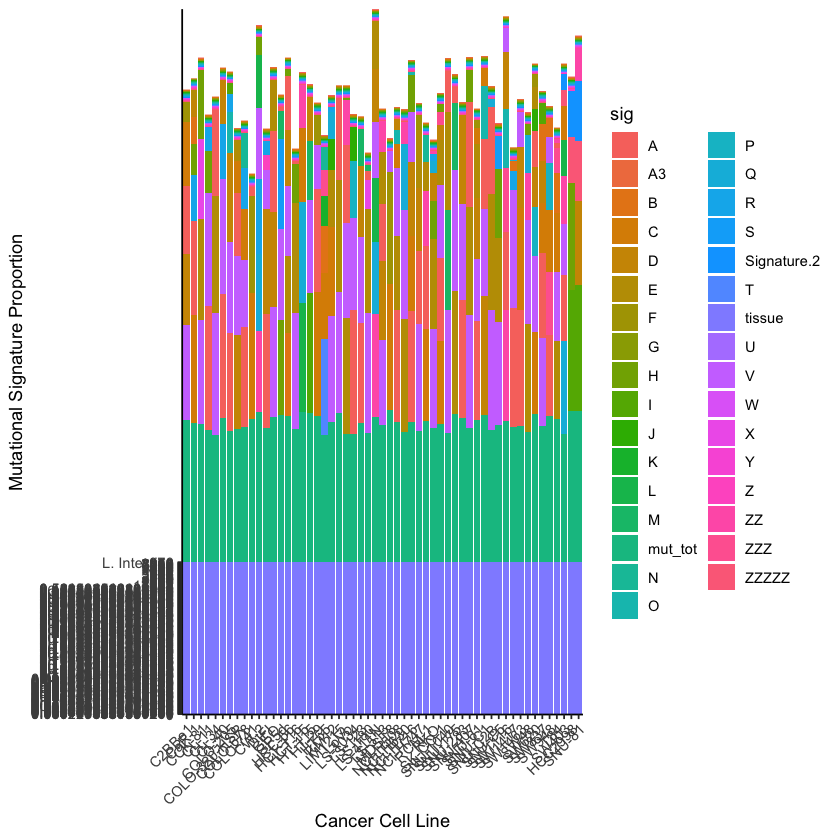

In [76]:
ggplot(sigs_melt, aes(sample, value, fill = sig)) +
  geom_col() +
  #scale_fill_brewer() +
  theme(axis.text.x=element_text(angle = 45, hjust = 1)) +
  xlab("Cancer Cell Line") +
  ylab("Mutational Signature Proportion") +
  scale_x_discrete(limits = list1) +
  theme_bw() +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(colour = "black"))

In [77]:
enrich_tot <- unique(cosmic_mut_all_sort)
enrich_tot$Mut_TCW <- "0"
enrich_tot$Mut_C <- "0"
enrich_tot$Con_TCW <- "0"
enrich_tot$Con_C <- "0"
mut <- data.frame(do.call('rbind', strsplit(as.character(enrich_tot$mut),'>',fixed=T)))
enrich_tot$mut_ref <- mut[,1]

enrich_C <- subset(enrich_tot, mut_ref == "C")
enrich_CtoK <- subset(enrich_C, mut != "C>A") # Remove C>A mutations!

enrich_CtoK[which(enrich_CtoK$mut_ref == "C"),"Mut_C"] <- "1"

enrich_CtoK[which(enrich_CtoK$trinuc_mut == "T[C>G]A"),"Mut_TCW"] <- "1"
enrich_CtoK[which(enrich_CtoK$trinuc_mut == "T[C>G]T"),"Mut_TCW"] <- "1"
enrich_CtoK[which(enrich_CtoK$trinuc_mut == "T[C>T]A"),"Mut_TCW"] <- "1"
enrich_CtoK[which(enrich_CtoK$trinuc_mut == "T[C>T]T"),"Mut_TCW"] <- "1"

enrich_CtoK$Con_C <- str_count(enrich_CtoK$context, "C") + str_count(enrich_CtoK$context, "G")

enrich_CtoK$Con_TCW <- str_count(enrich_CtoK$context, "TCA") + str_count(enrich_CtoK$context, "TCT") + str_count(enrich_CtoK$context, "TGA") + str_count(enrich_CtoK$context, "TGT")

enrich_final <- enrich_CtoK[,16:20]
enrich_final$Mut_TCW <- as.integer(enrich_final$Mut_TCW)
enrich_final$Mut_C <- as.integer(enrich_final$Mut_C)

enrich_final <- ddply(enrich_final, "sample", numcolwise(sum))

rownames(enrich_final) <- enrich_final$sample
enrich_final$sample <- NULL
enrich_final$enrich_score <- (enrich_final$Mut_TCW / enrich_final$Con_TCW) / (enrich_final$Mut_C / enrich_final$Con_C)

enrich_matrix <- as.data.frame(enrich_final$Mut_TCW)
enrich_matrix$Mut_Denom <- enrich_final$Mut_C - enrich_final$Mut_TCW
enrich_matrix$Con_TCW <- enrich_final$Con_TCW
enrich_matrix$Con_Denom <- enrich_final$Con_C - enrich_final$Con_TCW
rownames(enrich_matrix) <- rownames(enrich_final)
colnames(enrich_matrix) <- c("Mut_TCW", "Mut_Denom", "Con_TCW", "Con_Denom")

enrich_matrix <- as.matrix(enrich_matrix)


exe_fisher <- function(x) {
  m <- matrix(unlist(x), ncol = 2, nrow = 2, byrow = T)
  f <- fisher.test(m)
  return(as.data.frame(f$p.value))
}

fishers <- t(as.data.frame(apply(enrich_matrix, 1, exe_fisher)))
fishers <- as.data.frame(fishers)

enrich_final$fisher_pval <- fishers$V1
enrich_final$bh_adj_qval <- p.adjust(enrich_final$fisher_pval, method = "BH")

enrich_final$Mut_Ratio <- enrich_final$Mut_TCW/(enrich_final$Mut_C - enrich_final$Mut_TCW)
enrich_final$Con_Ratio <- enrich_final$Con_TCW/(enrich_final$Con_C - enrich_final$Con_TCW)
enrich_final[which(enrich_final$Mut_Ratio < enrich_final$Con_Ratio), "bh_adj_qval"] <- 1
enrich_final$Mut_Ratio <- NULL
enrich_final$Con_Ratio <- NULL
enrich_final$sample <- rownames(enrich_final)
rownames(enrich_final) <- NULL

mut_sub <- subset(cell_line_mutload, tissue == "Endometrium")

mut_med_quantiles <- as.data.frame(t(quantile(mut_sub$mut_tot)))


mut_med_quantiles$tissue <- rownames(mut_med_quantiles)
colnames(mut_med_quantiles) <- c("low", "first", "med", "third", "high", "tissue")

In [79]:
mut_med_quantiles

low,first,med,third,high,tissue
177,794.5,1885,3312,4887,1


Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

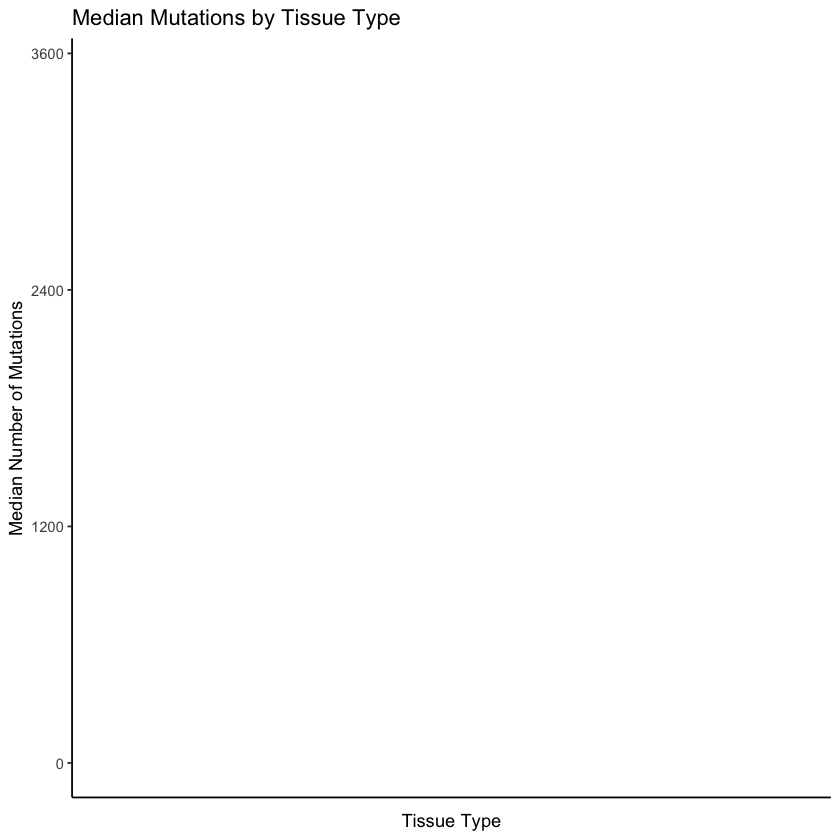

In [80]:
ggplot(mut_med_quantiles, aes(tissue, med)) +
  geom_col() +
  theme(axis.text.x=element_text(angle = 45, hjust = 1), legend.position = "none") +
  geom_errorbar(aes(ymin=first, ymax=third), width=.3) +
  scale_y_continuous(limits = c(0,3501),
    breaks = c(0,1200,2400,3600)) +
  xlab("Tissue Type") +
  ylab("Median Number of Mutations") +
  #geom_text(aes(label = freq), vjust = -0.2) +
  theme_bw() +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(colour = "black")) +
  scale_fill_gradient(low = "blue", high = "red") +
  scale_x_discrete(limits = c("Adrenal Gland","Autonomic Ganglia","Biliary Tract","Bladder","Bone","Breast","Cervix","CNS","Endometrium","Kidney","L. Intestine","Liver","Lung","NS","Oesophagus","Ovary","Pancreas","Placenta","Pleura","Prostate","Salivary Gland","S. Intestine","Skin","Soft Tissue","Stomach","Testis","Thyroid","Upper Aerodigestive Tract","Vulva","WBC")) +
  ggtitle("Median Mutations by Tissue Type")

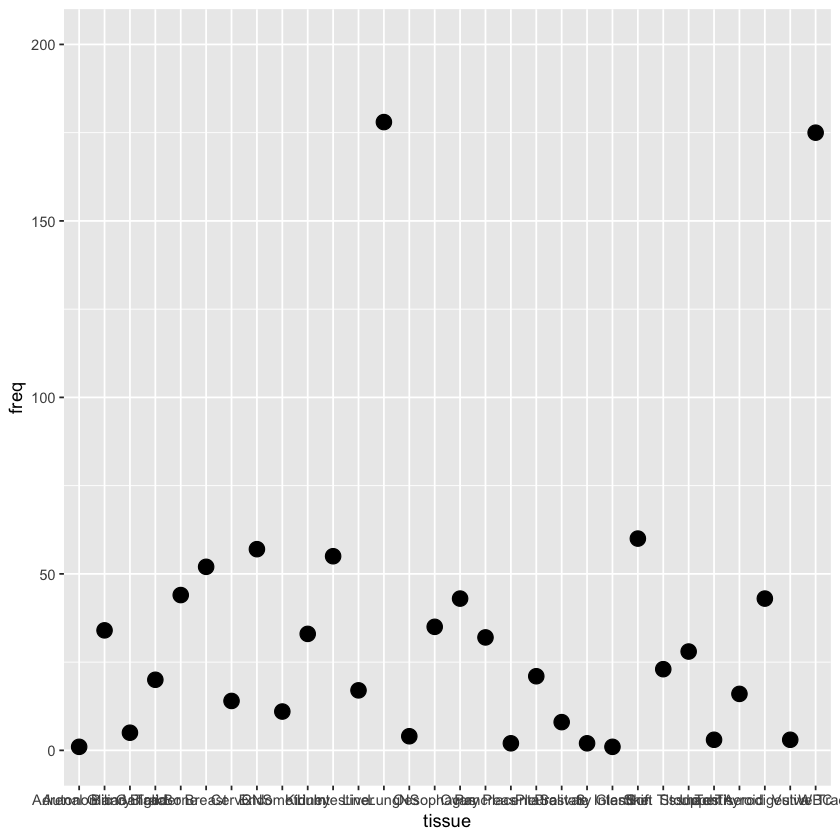

In [81]:
number <- as.data.frame(table(cosmic_tissue_type$tissue))
colnames(number) <- c("tissue", "freq")
ggplot(number, aes(tissue, freq)) +
  geom_point(size = 4) +
  ylim(0,200) +
  scale_x_discrete(limits = c("Adrenal Gland","Autonomic Ganglia","Biliary Tract","Bladder","Bone","Breast","Cervix","CNS","Endometrium","Kidney","L. Intestine","Liver","Lung","NS","Oesophagus","Ovary","Pancreas","Placenta","Pleura","Prostate","Salivary Gland","S. Intestine","Skin","Soft Tissue","Stomach","Testis","Thyroid","Upper Aerodigestive Tract","Vulva","WBC"))

In [88]:
sigs_tissues_individual <- subset(sigs_tissues, tissue == "L. Intestine")
head(sigs_tissues_individual)

,sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,weights.Signature.25,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,unknown,zAPOBEC.Sig,mut_tot,tissue
76,C2BBe1,0.1617102,0,0.00000000,0.1549067,0.16822886,0.00000000,0.07744519,0,0.00000000,⋯,0,0.0000000,0,0,0,0,0.20145858,0,338,L. Intestine
104,CaR-1,0.2330125,0,0.08368834,0.2929195,0.07484726,0.07184822,0.00000000,0,0.09215439,⋯,0,0.0000000,0,0,0,0,0.04038048,0,286,L. Intestine
107,CCK-81,0.0000000,0,0.00000000,0.0000000,0.00000000,0.26303180,0.00000000,0,0.16321047,⋯,0,0.1881096,0,0,0,0,0.11526911,0,2774,L. Intestine
120,CL-11,0.3966457,0,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0.10678144,⋯,0,0.0000000,0,0,0,0,0.10787548,0,220,L. Intestine
121,CL-34,0.2160526,0,0.00000000,0.0000000,0.00000000,0.33180008,0.00000000,0,0.00000000,⋯,0,0.0000000,0,0,0,0,0.06893742,0,1142,L. Intestine
122,CL-40,0.3977086,0,0.00000000,0.0000000,0.10776209,0.00000000,0.00000000,0,0.00000000,⋯,0,0.0000000,0,0,0,0,0.04563042,0,369,L. Intestine


In [89]:
length(sigs_tissues_individual)

[1] 35

In [90]:
sigs_tissues_individual_1 <- sigs_tissues_individual[order(sigs_tissues_individual$zAPOBEC.Sig),]
rownames(sigs_tissues_individual_1) <- c(1:nrow(sigs_tissues_individual_1))
sigs_tissues_individual_1[,"order"] <- rownames(sigs_tissues_individual_1)
head(sigs_tissues_individual_1)

sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,weights.Signature.26,weights.Signature.27,weights.Signature.28,weights.Signature.29,weights.Signature.30,unknown,zAPOBEC.Sig,mut_tot,tissue,order
C2BBe1,0.1617102,0,0.00000000,0.1549067,0.16822886,0.00000000,0.07744519,0,0.00000000,⋯,0.0000000,0,0,0,0,0.20145858,0,338,L. Intestine,1
CaR-1,0.2330125,0,0.08368834,0.2929195,0.07484726,0.07184822,0.00000000,0,0.09215439,⋯,0.0000000,0,0,0,0,0.04038048,0,286,L. Intestine,2
CCK-81,0.0000000,0,0.00000000,0.0000000,0.00000000,0.26303180,0.00000000,0,0.16321047,⋯,0.1881096,0,0,0,0,0.11526911,0,2774,L. Intestine,3
CL-11,0.3966457,0,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0.10678144,⋯,0.0000000,0,0,0,0,0.10787548,0,220,L. Intestine,4
CL-34,0.2160526,0,0.00000000,0.0000000,0.00000000,0.33180008,0.00000000,0,0.00000000,⋯,0.0000000,0,0,0,0,0.06893742,0,1142,L. Intestine,5
CL-40,0.3977086,0,0.00000000,0.0000000,0.10776209,0.00000000,0.00000000,0,0.00000000,⋯,0.0000000,0,0,0,0,0.04563042,0,369,L. Intestine,6


In [91]:
length(sigs_tissues_individual_1)

[1] 36

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 20 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 20 rows containing missing values (geom_point).”

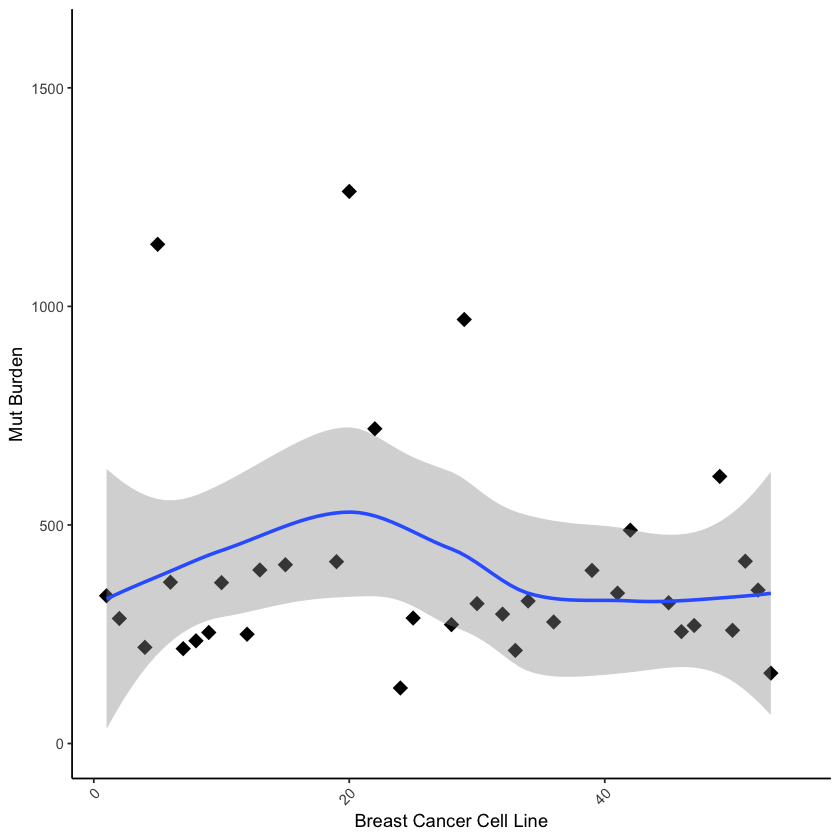

In [92]:
ggplot(sigs_tissues_individual_1, aes(as.numeric(order), mut_tot)) +
  geom_point(shape = 18, size = 4) +
  geom_smooth(span = 0.75) +
  theme(axis.text.x=element_text(angle = 45, hjust = 1)) +
  xlab("Breast Cancer Cell Line") +
  ylab("Mut Burden") +
  ylim(0,1600) +
  theme_bw() +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(colour = "black"))

In [93]:
sigs_enrich <- merge(sigs_tissues, enrich_final, by = "sample")
head(sigs_enrich)

sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,zAPOBEC.Sig,mut_tot,tissue,Mut_TCW,Mut_C,Con_TCW,Con_C,enrich_score,fisher_pval,bh_adj_qval
201T,0.1635878,0.0000000,0,0.1220388,0.2549915,0.0000000,0.0000000,0,0.00000000,⋯,0.000000,428,Lung,12,97,243,2173,1.1062747,7.415535e-01,0.99282750
22RV1,0.2614879,0.0000000,0,0.0000000,0.0000000,0.3275242,0.0000000,0,0.00000000,⋯,0.000000,1810,Prostate,5,392,870,9003,0.1319933,1.791741e-11,1.00000000
23132-87,0.0000000,0.0000000,0,0.0000000,0.0000000,0.4347781,0.0000000,0,0.00000000,⋯,0.000000,1794,Stomach,12,350,820,8011,0.3349547,4.029958e-06,1.00000000
42-MG-BA,0.2373844,0.0000000,0,0.1712615,0.1762817,0.0000000,0.0000000,0,0.00000000,⋯,0.000000,217,CNS,8,50,120,1108,1.4773333,2.486648e-01,0.71047080
451Lu,0.0000000,0.0000000,0,0.5484138,0.0000000,0.0000000,0.3180342,0,0.00000000,⋯,0.000000,618,Skin,24,161,379,3428,1.3483013,1.267546e-01,0.50701840
5637,0.1557857,0.0609748,0,0.2520327,0.1160934,0.0000000,0.0000000,0,0.06786217,⋯,0.143348,603,Bladder,33,158,433,3476,1.6766744,3.332793e-03,0.02635232


In [94]:
sigs_enrich_tcw <- merge(sigs_enrich, tca_tct, by = "sample")
head(sigs_enrich_tcw)

sample,weights.Signature.1,weights.Signature.2,weights.Signature.3,weights.Signature.4,weights.Signature.5,weights.Signature.6,weights.Signature.7,weights.Signature.8,weights.Signature.9,⋯,mut_tot,tissue,Mut_TCW,Mut_C,Con_TCW,Con_C,enrich_score,fisher_pval,bh_adj_qval,tca_tct
201T,0.1635878,0.0000000,0,0.1220388,0.2549915,0.0000000,0.0000000,0,0.00000000,⋯,428,Lung,12,97,243,2173,1.1062747,7.415535e-01,0.99282750,0.042713568
22RV1,0.2614879,0.0000000,0,0.0000000,0.0000000,0.3275242,0.0000000,0,0.00000000,⋯,1810,Prostate,5,392,870,9003,0.1319933,1.791741e-11,1.00000000,0.007352941
23132-87,0.0000000,0.0000000,0,0.0000000,0.0000000,0.4347781,0.0000000,0,0.00000000,⋯,1794,Stomach,12,350,820,8011,0.3349547,4.029958e-06,1.00000000,0.016590389
42-MG-BA,0.2373844,0.0000000,0,0.1712615,0.1762817,0.0000000,0.0000000,0,0.00000000,⋯,217,CNS,8,50,120,1108,1.4773333,2.486648e-01,0.71047080,0.045000000
451Lu,0.0000000,0.0000000,0,0.5484138,0.0000000,0.0000000,0.3180342,0,0.00000000,⋯,618,Skin,24,161,379,3428,1.3483013,1.267546e-01,0.50701840,0.094370861
5637,0.1557857,0.0609748,0,0.2520327,0.1160934,0.0000000,0.0000000,0,0.06786217,⋯,603,Bladder,33,158,433,3476,1.6766744,3.332793e-03,0.02635232,0.128252788


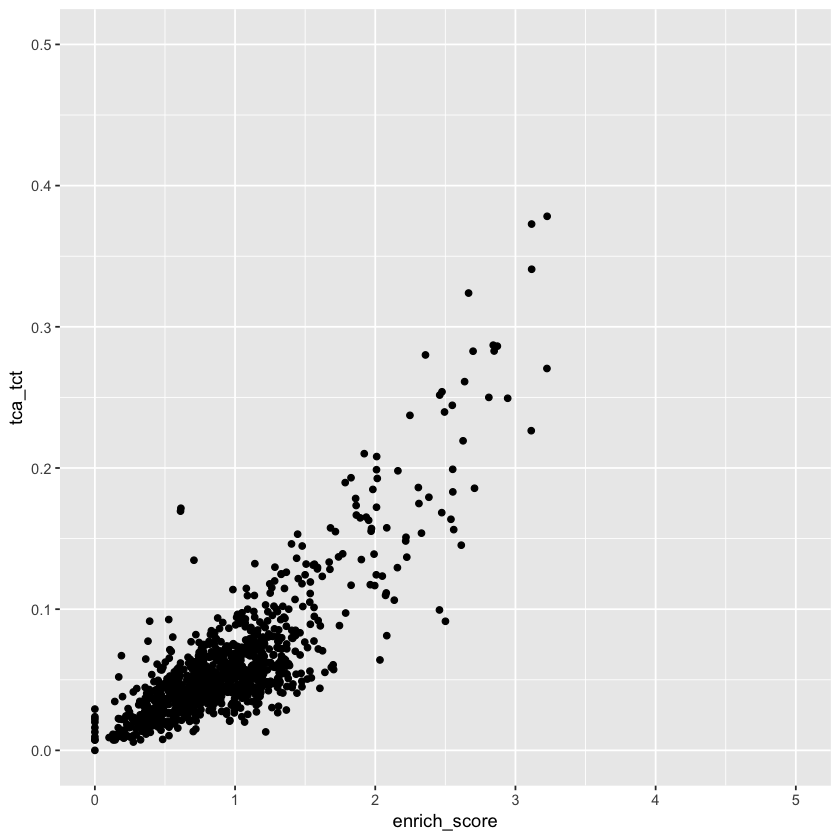

In [95]:
ggplot(sigs_enrich_tcw, aes(enrich_score, tca_tct)) +
  geom_point() +
  xlim(0,5) +
  ylim(0,0.5)

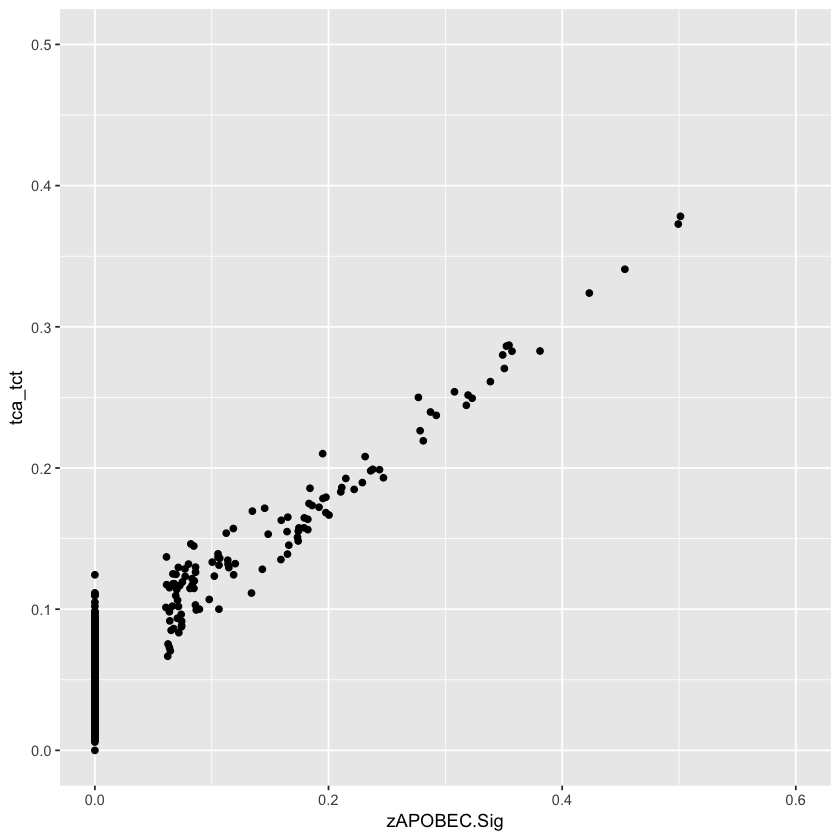

In [96]:
ggplot(sigs_enrich_tcw, aes(zAPOBEC.Sig, tca_tct)) +
  geom_point() +
  xlim(0,0.6) +
  ylim(0,0.5)